# Toy model for xrb_layered

We describe the reasoning for how to build the model used in xrb_layered. The toy model is meant to capture the physics of the relevant zones in the MESA model, while being easy to build. The code to build it is using the complete Helmoltz EOS in ```toy_atm/init_1d.H```. 

## First, observe the temperature profile of the MESA model

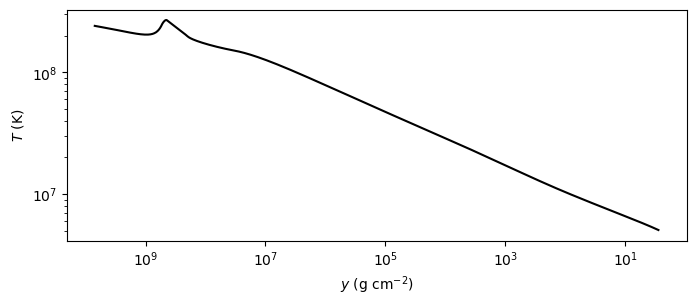

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import mesa.py_mesa_reader as mr
mesa_prof = mr.MesaData("mesa/profile37.data")

GM = 6.6726e-8 * 1.4 * 1.989e33
RNS = 12e5
g0 = GM/RNS**2

y_mesa = mesa_prof.pressure/g0

plt.figure(figsize=(8,3))
plt.xlabel(r"$y$ (g cm$^{-2}$)")
plt.ylabel(r"$T$ (K)")

plt.loglog(y_mesa, mesa_prof.T, 'k-')
plt.gca().invert_xaxis()

# plt.xlim([1e9,1e7])
# plt.ylim([1e8,3e8])

plt.show()

#### We can distinguish 4 broad zones with different temperature profiles:

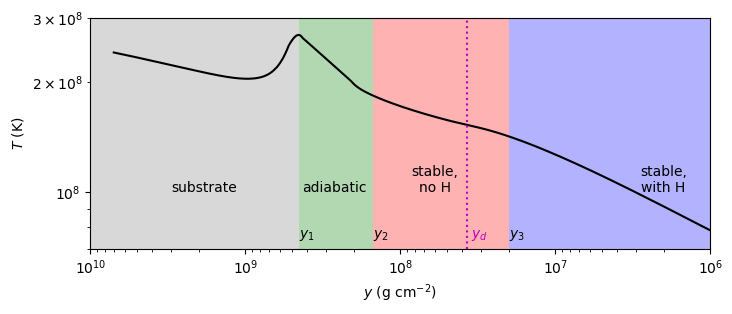

In [2]:
# These numbers are fit "by eye"
y1 = 4.5e8
y2 = 1.5e8
y3 = 2e7

def zones_plot():

    plt.figure(figsize=(8,3))
    plt.xlabel(r"$y$ (g cm$^{-2}$)")
    plt.ylabel(r"$T$ (K)")

    plt.loglog(y_mesa, mesa_prof.T, 'k-', label="MESA")
    plt.gca().invert_xaxis()

    plt.xlim([1e10,1e6])
    plt.ylim([7e7,3e8])

    plt.axvspan(1e10,y1, color='gray', alpha=0.3, lw=0)
    plt.axvspan(y1,y2, color='green', alpha=0.3, lw=0)
    plt.axvspan(y2,y3, color='red', alpha=0.3, lw=0)
    plt.axvspan(y3, 1e6, color='blue', alpha=0.3, lw=0)


    # plt.gca().twinx().semilogx(y_mesa,mesa_prof.grada)
    # plt.gca().twinx().semilogx(y_mesa,mesa_prof.h1, 'b--')

zones_plot()

plt.text(3e9,1e8,'substrate')

plt.text(4.3e8,1e8,'adiabatic')
plt.text(y1,7.5e7,r"$y_1$")

plt.text(6e7,1e8,'stable,\nno H',ha='center')
plt.text(y2,7.5e7,r"$y_2$")

plt.text(2e6,1e8,'stable,\nwith H',ha='center')
plt.text(y3,7.5e7,r"$y_3$")

# We know the depletion depth from the physics
yd = 3.7e7
plt.axvline(yd,ls=':',color='m')
plt.text(0.95*yd,7.5e7,r"$y_d$",color='m')

plt.show()

The zones are:
- **Gray**: The substrate/buffer layer. We set the composition to pure iron. We can assume an isothermal profile for simplicity.
- **Green**: The adiabatic zone. This is where convection will become unstable initially. It is composed of pure He plus a small percentage of CNO, but no hydrogen.
- **Red**: Stable, hydrogen deficient zone. Approximately nothing is burning here, so the flux is small, and therefore the T profile shallow.
- **Blue**: Stable, solar composition zone. Hydrogen is burning via hot CNO here, which steepens the T profile a bit.

The exact composition is determined by the following analytic expression from Cumming & Bildsten 2000:
$$X(y)=X_0(1-y/y_d).$$
The depletion depth $y_d$ is inside of the red zone. This is because the flux from hot CNO ramps up from a small value, and it is only in the blue zone where it really sets the temperature profile.

#### Get best fitting power-laws in each zone (except the iron zone where we assume isothermal).

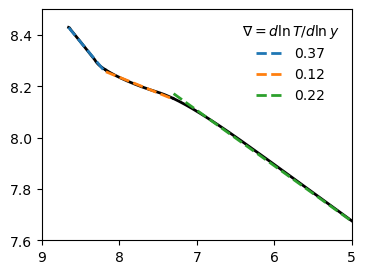

In [3]:
from scipy.stats import linregress

plt.figure(figsize=(4,3))

y,T = y_mesa[::-1], mesa_prof.T[::-1]

dels = []

i_left = np.argmin(abs(y-y1)) # index of left green boundary

for y_right in (y2,y3,min(y)):
    
    i_right = np.argmin(abs(y-y_right))
    
    xx = np.log10(y[i_left:i_right])
    ff = np.log10(T[i_left:i_right])
    
    res = linregress(xx,ff)
    dels.append(res.slope)
    
    plt.plot(xx,ff,'k',lw=2)
    plt.plot(xx, res.intercept+res.slope*xx, '--', lw=2, label="%.2f"%res.slope)
    
    i_left = i_right
    
plt.xlim([5,9])
plt.ylim([7.6,8.5])
plt.legend(frameon=False, title=r"$\nabla=d\ln T/d\ln y$")
plt.gca().invert_xaxis()

0.37 should be close to $\nabla_{\rm ad}=(8-6\beta)/(32-24\beta-3\beta^2)$

In [4]:
beta = mesa_prof.pgas_div_ptotal
del_ad =  (8-6*beta) / (32-24*beta-3*beta**2)
print(f"del_ad (beta) is on average {np.mean(del_ad[np.logical_and(y_mesa < y1, y_mesa > y2)]):.4f} in that zone")
print(f"del_ad (from MESA) is on average {np.mean(mesa_prof.grada[np.logical_and(y_mesa < y1, y_mesa > y2)]):.4f} in that zone")

del_ad (beta) is on average 0.3998 in that zone
del_ad (from MESA) is on average 0.3783 in that zone


Which is the obviously close to the ideal gas value ($\beta=1$, $\nabla_{\rm ad}=0.4$). We probably have corrections due to degenerate electrons which soften the gradient.

We are now ready to:

## Create the toy model

We'll store it in a namedtuple object

In [5]:
from collections import namedtuple
toy = namedtuple("toy", ['T','rho','y','X','Y','Zcno','Zfe'])

#### Make the (continuous) temperature profile

We need to set two temperatures: that of the isothermal iron layer, and at the base of the adiabatic zone

In [6]:
# T_star = 2e8
T_star = 1e8
T_base = 2.75e8

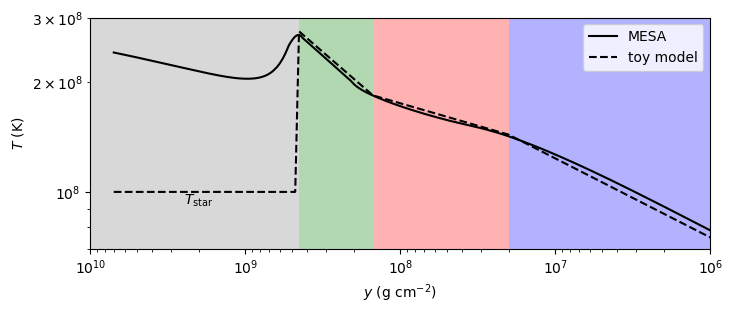

In [7]:
yya = np.logspace(np.log10(max(y_mesa)), np.log10(y1))[:-1]
Ta = T_star*np.ones(len(yya))

yyb = np.logspace(np.log10(y1), np.log10(y2))
Tb = T_base * (yyb/y1)**dels[0]
# Tb = T_base * (yyb/y1)**0.4


yyc = np.logspace(np.log10(y2), np.log10(y3))[1:]
Tc = Tb[-1] * (yyc/y2)**dels[1]

yyd = np.logspace(np.log10(y3), np.log10(min(y_mesa)))[1:]
Td = Tc[-1] * (yyd/y3)**dels[2]

toy.y = np.concatenate((yya,yyb,yyc,yyd))
toy.T = np.concatenate((Ta,Tb,Tc,Td))

zones_plot()
plt.loglog(toy.y, toy.T, 'k--', label="toy model")
plt.legend()

plt.text(2e9,T_star*0.95,r"$T_{\rm star}$",ha='center',va='center')

plt.show()

We have some freedom in setting $T_{\rm star}$. We might want to make that layer very cold to create a "buoyancy wall" in order to prevent convective undershoot into that region.

#### Set the composition profile

In [8]:
X0 = 0.7
Zcno = 0.02

In [9]:
# Metals
toy.Zfe = np.concatenate((np.ones(len(yya)), np.zeros(len(yyb)+len(yyc)+len(yyd))))
toy.Zcno = np.concatenate((np.zeros(len(yya)), Zcno*np.ones(len(yyb)+len(yyc)+len(yyd))))

# Hydrogen
X0 = 0.7
toy.X = X0 * np.maximum(0, 1-toy.y/yd)

toy.Y = 1 - toy.X - toy.Zfe - toy.Zcno

# sanity check
assert max(toy.Y)<=1.0 and min(toy.Y)>=0

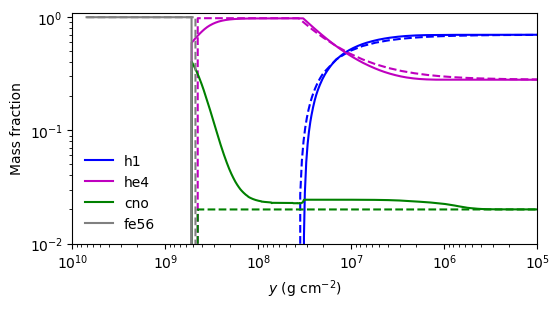

In [10]:
# Plot
plt.figure(figsize=(6,3))
plt.xlabel(r"$y$ (g cm$^{-2}$)")
plt.ylabel(r"Mass fraction")

plt.loglog(y_mesa, mesa_prof.h1,'b-', label='h1')
plt.loglog(toy.y, toy.X, 'b--')
plt.loglog(y_mesa, mesa_prof.he4,'m-', label='he4')
plt.loglog(toy.y, toy.Y, 'm--')

cno_mesa = mesa_prof.c12
for iso in ("c13","n13","n14","n15","o14","o15","o16","o17","o18","f17","f18","f19"):
    cno_mesa += mesa_prof.data(iso)
plt.loglog(y_mesa, cno_mesa, 'g-', label='cno')
plt.loglog(toy.y, toy.Zcno, 'g--')

plt.loglog(y_mesa, mesa_prof.fe56,'-', color='gray', label='fe56')
plt.loglog(toy.y, toy.Zfe, '--', color='gray')

plt.legend(loc=3, frameon=False)
plt.ylim([1e-2,1.1])
plt.xlim([1e5,1e10])
plt.gca().invert_xaxis()
plt.show()

#### We can write down a simplified EOS (gas+radiation+degenerate electrons) to get the density profile

In [11]:
from scipy.optimize import fsolve

# Constants
kB = 1.380658e-16
arad = 7.5657e-15
mp = 1.67e-24

toy.rho = np.zeros(len(toy.T))
    
for i in range(len(toy.T)):
    
    # Mean-molecular weights
    if toy.Y[i]>0:
        # If there is helium, then the Z is CNO with <A>=15
        mu_I = 1/(toy.X[i] + toy.Y[i]/4 + toy.Zcno[i]/15)
    else:
        # Otherwise, the Z is iron
        mu_I = 56

    mu_e = 2/(1+toy.X[i])
    mu = 1/(1/mu_I + 1/mu_e)
    
    T = toy.T[i]
    
    # ion pressure
    def pgas(rho):
        return rho*kB*T/mu_I/mp
    
    # Electron pressure
    def pe(rho):
        rY = rho/mu_e # rho*Ye = rho/mu_e
        pednr = 9.91e12 * (rY)**(5/3)     
        pedr = 1.231e15 * (rY)**(4/3)
        ped = 1/np.sqrt((1/pedr**2)+(1/pednr**2))
        pend = kB/mp*rY*T
        pe = np.sqrt(ped**2 + pend**2)
        return pe
    
    # radiation pressure
    prad = arad*T**4/3
    
    # Real total pressure
    true_ptot = g0 * toy.y[i]
    
    # Solve for rho
    error = lambda rho: true_ptot - (pgas(rho) + pe(rho) + prad)
    
    toy.rho[i] = fsolve(error, x0=1e7)[0]

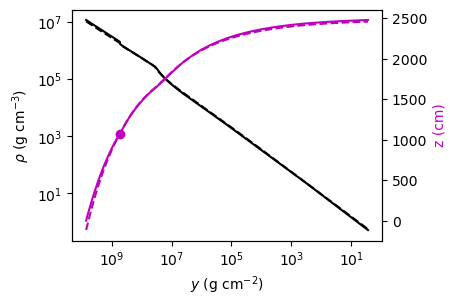

In [12]:
plt.figure(figsize=(4,3))
plt.xlabel(r"$y$ (g cm$^{-2}$)")
plt.ylabel(r"$\rho$ (g cm$^{-3}$)")

plt.loglog(y_mesa, mesa_prof.Rho, 'k-')
plt.loglog(toy.y, toy.rho, 'k--')

# plt.xlim([1e7,1e10])
# plt.ylim([5e4,5e7])

plt.gca().invert_xaxis()


# We can also get the radial extent by integrating the HSE equation

axb = plt.gca().twinx()
axb.set_ylabel("z (cm)", color='m')
axb.semilogx(y_mesa, mesa_prof.R_cm - 12e5, 'm-')

from scipy.integrate import cumulative_trapezoid as ct
# z = -1/g0 * ct(1/toy.rho, x=toy.y*g0)
# z = -1 * ct(1/toy.rho, x=toy.y)
# axb.semilogx(toy.y[1:], z, 'm--')


# integrate in and out from the middle
i0 = np.argwhere(mesa_prof.fe56 > 1e-10)[0]
H0 = mesa_prof.R_cm[i0][0] - 12e5
axb.semilogx(y_mesa[i0], H0, 'mo')

k0 = np.argmin(abs(toy.y - y_mesa[i0]))

z1 = ct(-1/toy.rho[k0:], x=toy.y[k0:]) + H0
# axb.semilogx(toy.y[k0+1:], z1, 'm--')


# z2 = ct(-1/toy.rho[:k0], x=toy.y[:k0])
# axb.semilogx(toy.y[:k0-1], z2, 'm--')

z2 = ct(-1/toy.rho[:k0+1][::-1], x=toy.y[:k0+1][::-1])[::-1] + H0
# axb.semilogx(toy.y[:k0], z2, 'm--')

z = np.concatenate((z2,[H0],z1))
axb.semilogx(toy.y, z, 'm--')


plt.show()

There are a few additional details that were omitted here, but that are considered in the code to build the actual model:
- The transition from pure iron to no iron is done with a hyperbolic tangent function of width $\delta$, another input parameter.
- The CNO species are split between $^{14}$O and $^{15}$O  with ratio determined by their beta decay times (70.606/122.24)
- The integration begins at the base ($z=H_{\rm star}$), using $T_{\rm base}$ and also $\rho_{\rm base}$, instead of y1. We therefore need these values:

In [13]:
print(f"At y=y1, T=Tbase (y=y1)")
print(f"Density = {toy.rho[np.argmin(abs(toy.y-y1))]:.2e}")
print(f"Height = {z[np.argmin(abs(toy.y-y1))]:.1f}")

At y=y1, T=Tbase (y=y1)
Density = 1.45e+06
Height = 1120.0


#### What is the burning like in this model? We can investigate with pynucastro

In [14]:
import pynucastro as pyna

# Code for CNO_extras network
# https://github.com/AMReX-Astro/Microphysics/blob/main/networks/CNO_extras/CNO_extras.py
rl = pyna.ReacLibLibrary()

h_burn = rl.linking_nuclei(["h1", "he4",
                            "c12", "c13",
                            "n13", "n14", "n15",
                            "o14", "o15", "o16","o17","o18",
                            "f17", "f18","f19",
                            "ne18", "ne19", "ne20",
                            "mg22", "mg24"],
                           with_reverse=True)

rc = pyna.StarKillerCxxNetwork(libraries=[h_burn], inert_nuclei=["fe56"])
# print(rc)

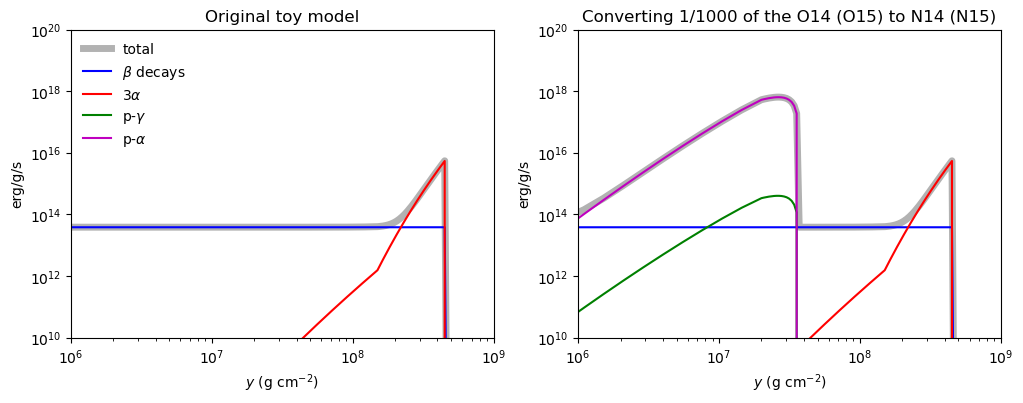

In [15]:
MeV2erg = 1.6021772e-06

def burn_plot(ax, model, perturb_cno=False):

    comp = pyna.Composition(rc.get_nuclei())
    eps_nuc_tot = []
    eps_3a = []
    eps_beta = []
    eps_pg = []
    eps_pa = []

    for i in range(len(toy.T)):

        comp.set_nuc("p", model.X[i])
        comp.set_nuc("he4", model.Y[i])
        comp.set_nuc("fe56", model.Zfe[i])

        o15 = model.Zcno[i] / (1.0 + 70.606/122.24)
        o14 = model.Zcno[i] - o15
        
        if perturb_cno:
            # Convert 1/1000 of the o14 (o15) to n14 (n15)
            
            comp.set_nuc("n14", 0.001*o14)
            comp.set_nuc("n15", 0.001*o15)
            
            o14 *= 0.999
            o15 *= 0.999

        comp.set_nuc("o14", o14)
        comp.set_nuc("o15", o15)

        rhoi,Ti = model.rho[i], model.T[i]

        eps_nuc_tot.append(rc.evaluate_energy_generation(rhoi,Ti,comp))

        eps_3a.append(0)
        eps_beta.append(0)
        eps_pg.append(0)
        eps_pa.append(0)

        rates = rc.evaluate_rates(rhoi,Ti,comp)
        for rate in rates:
            eps = rates[rate] * rate.Q * MeV2erg / mp

            if rate.weak:
                eps_beta[-1] += eps

            elif rate.fname == 'he4_he4_he4__c12':
                eps_3a[-1] = eps

            elif pyna.Nucleus("p") in rate.reactants:
                if len(rate.products) == 1:
                    eps_pg[-1] += eps
                elif pyna.Nucleus("he4") in rate.products:
                    eps_pa[-1] += eps

    ax.loglog(model.y, eps_nuc_tot, 'k-', label='total', lw=5, alpha=0.3)
    ax.loglog(model.y, eps_beta, 'b-', label=r'$\beta$ decays')
    ax.loglog(model.y, eps_3a, 'r-', label=r'$3\alpha$')
    ax.loglog(model.y, eps_pg, 'g-', label=r'p-$\gamma$')
    ax.loglog(model.y, eps_pa, 'm-', label=r'p-$\alpha$')

    ax.set_ylim([1e10,1e20])
    ax.set_xlim([1e6,1e9])
    ax.set_ylabel("erg/g/s")
    ax.set_xlabel(r"$y$ (g cm$^{-2}$)")

fig,axes = plt.subplots(1,2,figsize=(12,4))

burn_plot(axes[0], model=toy)
axes[0].legend(frameon=False, loc=2)

burn_plot(axes[1], model=toy, perturb_cno=True)

axes[0].set_title("Original toy model")
axes[1].set_title("Converting 1/1000 of the O14 (O15) to N14 (N15)")

plt.show()

This model is close to runaway helium burning, but experience shows that we can accelerate the evolution by *kicking* the initial model, which we demonstrate in the next part.

The plot on the right is more of a sanity check. We imagine perturbing the stable hot-CNO cycle by instantly decaying a small fraction of the oxygen. Then, new (p,g) and (p,alpha) reactions are available, which dominate the burning. But those reactions are only possible above the depletion column depth ($y<y_d\sim 3.7\times 10^7$ g cm$^{-2}$)

## *Kicked* initial model

The idea is to increase the temperature at the base of the helium layer ($T_{\rm base}\rightarrow T_{\rm base}'$). To simulate real convective growth, the adiabatic zone keeps the same slope, and just meets the first stable layer (red in drawings above) at a lower column ($y_2\rightarrow y_2'$). It is straightforward to show that:
$$y_2'=y_2\left(\frac{T_{\rm base}'}{T_{\rm base}}\right)^{\frac{1}{\nabla_1-\nabla_2}}\,,$$
where $\nabla_1$ and $\nabla_2$ are the power law indices of the adiabatic and first radiative zone.

In [16]:
T_base_p = 3.5e8
y2_p = y2 * (T_base_p/T_base) ** (1/(dels[1]-dels[0]))
print(f"New location y2 = {y2_p:.2e}")

New location y2 = 5.60e+07


In [17]:
toy2 = namedtuple("toy", ['T','rho','y','X','Y','Zcno','Zfe'])

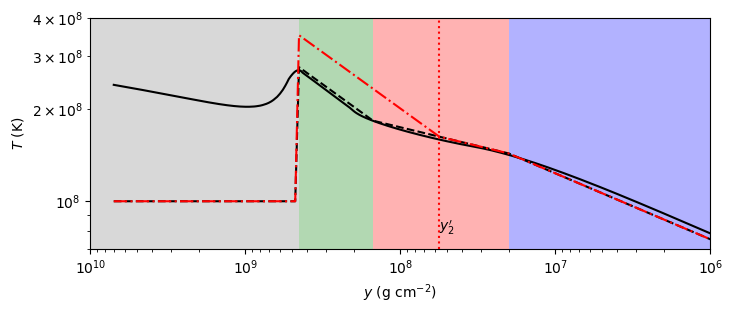

In [18]:
# yya,Ta unchan|ged

yyb = np.logspace(np.log10(y1), np.log10(y2_p))
Tb = T_base_p * (yyb/y1)**dels[0]

yyc = np.logspace(np.log10(y2_p), np.log10(y3))[1:]
Tc = Tb[-1] * (yyc/y2_p)**dels[1]

# yyd,Yd unchanged

toy2.y = np.concatenate((yya,yyb,yyc,yyd))
toy2.T = np.concatenate((Ta,Tb,Tc,Td))

zones_plot()
plt.loglog(toy.y, toy.T, 'k--', label="original toy model")
plt.loglog(toy2.y, toy2.T, 'r-.', label="kicked toy model")
plt.ylim([7e7,4e8])

plt.axvline(y2_p, color='r', ls=':')
plt.text(y2_p, 8e7, r"$y_2'$")

plt.show()

In [19]:
# Set the rest of the model (same code as before but compact)

toy2.Zfe = np.concatenate((np.ones(len(yya)), np.zeros(len(yyb)+len(yyc)+len(yyd))))
toy2.Zcno = np.concatenate((np.zeros(len(yya)), Zcno*np.ones(len(yyb)+len(yyc)+len(yyd))))
toy2.X = X0 * np.maximum(0, 1-toy2.y/yd)
toy2.Y = 1 - toy2.X - toy2.Zfe - toy2.Zcno

toy2.rho = np.zeros(len(toy2.T))
for i in range(len(toy2.T)):
    if toy2.Y[i]>0:
        mu_I = 1/(toy.X[i] + toy.Y[i]/4 + toy.Zcno[i]/15)
    else:
        mu_I = 56
    mu_e = 2/(1+toy2.X[i])
    mu = 1/(1/mu_I + 1/mu_e)
    T = toy2.T[i]
    def pgas(rho):
        return rho*kB*T/mu_I/mp
    def pe(rho):
        rY = rho/mu_e # rho*Ye = rho/mu_e
        pednr = 9.91e12 * (rY)**(5/3)     
        pedr = 1.231e15 * (rY)**(4/3)
        ped = 1/np.sqrt((1/pedr**2)+(1/pednr**2))
        pend = kB/mp*rY*T
        pe = np.sqrt(ped**2 + pend**2)
        return pe
    prad = arad*T**4/3
    true_ptot = g0 * toy2.y[i]
    error = lambda rho: true_ptot - (pgas(rho) + pe(rho) + prad)
    toy2.rho[i] = fsolve(error, x0=1e7)[0]
    
print(f"Density where T=Tbase (y=y1) is {toy2.rho[np.argmin(abs(toy2.y-y1))]:.3e}")

Density where T=Tbase (y=y1) is 1.386e+06


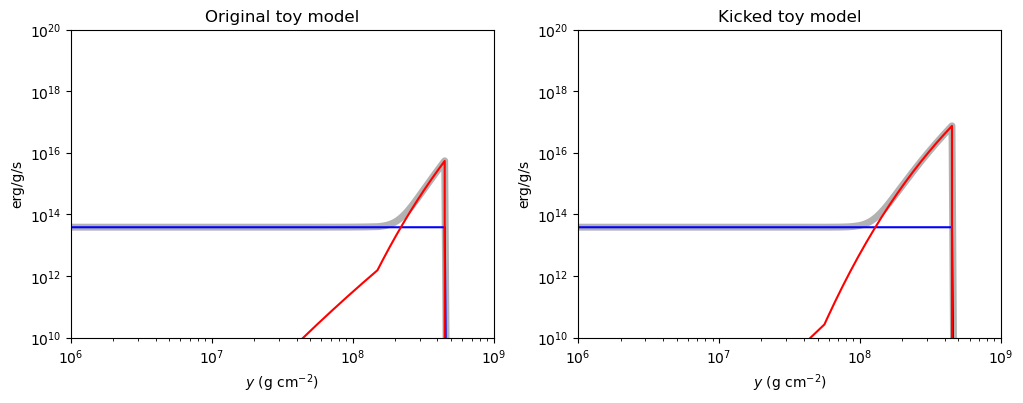

In [20]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
burn_plot(axes[0], model=toy)
burn_plot(axes[1], model=toy2)
axes[0].set_title("Original toy model")
axes[1].set_title("Kicked toy model")
plt.show()

We increase the peak burning by about an order of magnitude.